# Customer Behavior Project - Feature Engineering

**Dataset:** Online Retail  
**Objective:** Prepare feature set for clustering and classification models.

- Author: Tarık Buğra Ay
- Date: May, 2025

This notebook builds on the cleaned data prepared in `01_eda_and_cleaning.ipynb`.


In [15]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the directory of the current notebook
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # go up one level from /notebooks

# Define data paths
data_path = os.path.join(base_dir, 'data', 'Online Retail.xlsx')
output_transactions_path = os.path.join(base_dir, 'outputs', 'cleaned_transactions.csv')
output_customer_path = os.path.join(base_dir, 'outputs', 'customer_summary.csv')

# Check the resolved paths
print(f"Data path: {data_path}")
print(f"Cleaned transactions path: {output_transactions_path}")
print(f"Customer summary path: {output_customer_path}")

# Load data
df_clean = pd.read_csv(output_transactions_path, parse_dates=['InvoiceDate'])
customer_summary = pd.read_csv(output_customer_path)

print(f" Data loaded. df_clean shape: {df_clean.shape}, customer_summary shape: {customer_summary.shape}")


Data path: c:\Users\Tarık Buğra Ay\Desktop\BI_PROJECT\data\Online Retail.xlsx
Cleaned transactions path: c:\Users\Tarık Buğra Ay\Desktop\BI_PROJECT\outputs\cleaned_transactions.csv
Customer summary path: c:\Users\Tarık Buğra Ay\Desktop\BI_PROJECT\outputs\customer_summary.csv
 Data loaded. df_clean shape: (406789, 15), customer_summary shape: (4371, 8)


## Create and Explore Time-Based Features

We enrich the data with time-based features:

- Split `InvoiceDate` into `Date` and `Time`.
- Extract `DayOfWeek` (0 = Monday, 6 = Sunday).
- Flag `IsWeekend` (Saturday or Sunday).
- Define `TimeOfDay` buckets (Morning, Afternoon, Evening, Night).

We then explore the distribution of transactions and spend across these groups to decide if they are useful for modeling.


Unique invoices by Day of Week:
DayOfWeek
0    3512
1    3891
2    4110
3    4977
4    3354
6    2342
Name: InvoiceNo, dtype: int64

Unique invoices by Time of Day:
TimeOfDay
Afternoon    14020
Evening        502
Morning       7665
Name: InvoiceNo, dtype: int64


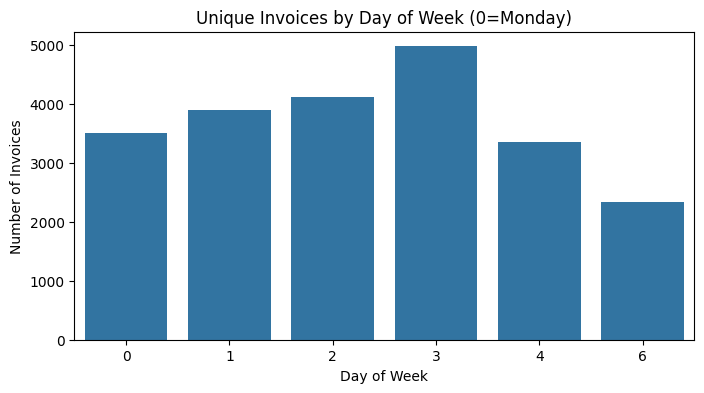

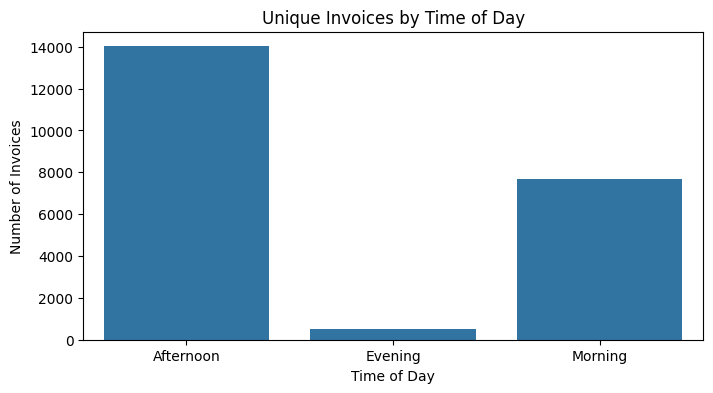

In [2]:
# time-based columns
df_clean['Date'] = df_clean['InvoiceDate'].dt.date
df_clean['Time'] = df_clean['InvoiceDate'].dt.time
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek  # 0 = Monday
df_clean['IsWeekend'] = df_clean['DayOfWeek'] >= 5

def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df_clean['TimeOfDay'] = df_clean['InvoiceDate'].dt.hour.apply(get_time_of_day)

# transaction counts by day of week
day_counts = df_clean.groupby('DayOfWeek')['InvoiceNo'].nunique()
print("Unique invoices by Day of Week:")
print(day_counts)

#  transaction counts by time of day
time_counts = df_clean.groupby('TimeOfDay')['InvoiceNo'].nunique()
print("\nUnique invoices by Time of Day:")
print(time_counts)

# Plot distributions
import seaborn as sns
import matplotlib.pyplot as plt

# Day of Week plot
plt.figure(figsize=(8,4))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Unique Invoices by Day of Week (0=Monday)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Invoices')
plt.show()

# Time of Day plot
plt.figure(figsize=(8,4))
sns.barplot(x=time_counts.index, y=time_counts.values)
plt.title('Unique Invoices by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Invoices')
plt.show()


**Observation on Date Coverage:**  
The dataset contains no records for Saturdays (weekday 5), confirming that the business was closed on Saturdays during the data period.



 ## One-Hot Encoding: Day of Week and Time of Day
 
 We create one-hot encoded (dummy) variables for:
 - `DayOfWeek` (Monday=0, Sunday=6), including a placeholder for missing Saturday (5).
 - `TimeOfDay` (Night, Morning, Afternoon, Evening), ensuring all categories are included even if missing in data.


In [3]:

# One-hot encode DayOfWeek
day_dummies = pd.get_dummies(df_clean['DayOfWeek'], prefix='Day')

# Ensure all days (0-6) are present
for col in range(7):
    col_name = f'Day_{col}'
    if col_name not in day_dummies.columns:
        day_dummies[col_name] = 0

# Sort columns to consistent order
day_dummies = day_dummies.sort_index(axis=1)

# One-hot encode TimeOfDay (assuming this column already exists in df_clean)
time_dummies = pd.get_dummies(df_clean['TimeOfDay'], prefix='Time')

# Ensure all time periods are present
for label in ['Night', 'Morning', 'Afternoon', 'Evening']:
    col_name = f'Time_{label}'
    if col_name not in time_dummies.columns:
        time_dummies[col_name] = 0

# Sort columns to consistent order
time_dummies = time_dummies.sort_index(axis=1)

# Combine into main DataFrame
df_clean = pd.concat([df_clean, day_dummies, time_dummies], axis=1)

# Confirm result
print("Final columns after one-hot encoding:")
print(df_clean.columns[-11:])  # Show last 11 columns (7 day + 4 time dummies)


Final columns after one-hot encoding:
Index(['Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6',
       'Time_Afternoon', 'Time_Evening', 'Time_Morning', 'Time_Night'],
      dtype='object')


 ## Calculate RFM (Recency, Frequency, Monetary) Features
 
 #### We will calculate:
- **Recency:** Days since last purchase. 
- **Frequency:** Number of unique purchases (invoices).
- **Monetary:** Total spend.
 
 These features will be computed at the **customer level** using the cleaned dataset.

 **How RFM was calculated:**
- Recency → Days since last purchase, using one day after max InvoiceDate as reference.
- Frequency → Number of unique invoices per customer.
- Monetary → Total spend (`Quantity × UnitPrice`) per customer.


In [4]:
import pandas as pd
import numpy as np

# Make sure we are using the cleaned dataset
df_rfm = df_clean.copy()

# Set reference date for recency calculation → one day after last invoice date
reference_date = df_rfm['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = df_rfm.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Amount': 'sum'
}).reset_index()

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)

# Check result
print("RFM sample:")
print(rfm.head())

# Summary statistics
print("\nRFM summary statistics:")
print(rfm.describe())

RFM sample:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          2      0.00
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

RFM summary statistics:
         CustomerID      Recency    Frequency       Monetary
count   4371.000000  4371.000000  4371.000000    4371.000000
mean   15300.145276    92.064974     5.075726    1898.894032
std     1722.310262   100.770046     9.332529    8220.235339
min    12346.000000     1.000000     1.000000   -4287.630000
25%    13813.500000    17.000000     1.000000     293.785000
50%    15301.000000    50.000000     3.000000     648.410000
75%    16778.500000   143.000000     5.000000    1611.860000
max    18287.000000   374.000000   248.000000  279489.020000


**Why we excluded zero or negative Monetary customers:**
- These cases mostly represent invoice corrections or accounting adjustments.
- They do not reflect meaningful customer purchase behavior.
- Excluding them gives us a clean base of “active spenders” for clustering and modeling.


In [ ]:
# Exclude customers with Monetary ≤ 0

# Filter the RFM dataframe
rfm_filtered = rfm[rfm['Monetary'] > 0].copy()

# Report before and after counts
original_count = rfm.shape[0]
filtered_count = rfm_filtered.shape[0]

print(f"Original number of customers: {original_count}")
print(f"Number of customers after excluding Monetary ≤ 0: {filtered_count}")
print(f"Number of excluded customers: {original_count - filtered_count}")

# Display summary statistics after filtering
print("\nFiltered RFM summary statistics:")
print(rfm_filtered.describe())

# Save filtered RFM to outputs
filtered_rfm_path = os.path.join(base_dir, "outputs", "rfm_filtered.csv")
rfm_filtered.to_csv(filtered_rfm_path, index=False)
print(f"\nFiltered RFM data saved to: {filtered_rfm_path}")


Original number of customers: 4371
Number of customers after excluding Monetary ≤ 0: 4321
Number of excluded customers: 50

Filtered RFM summary statistics:
         CustomerID      Recency    Frequency      Monetary
count   4321.000000  4321.000000  4321.000000  4.321000e+03
mean   15297.845869    90.360333     5.115714  1.923928e+03
std     1721.137878    99.138927     9.378291  8.264032e+03
min    12347.000000     1.000000     1.000000  3.552714e-15
25%    13812.000000    17.000000     1.000000  3.023600e+02
50%    15297.000000    50.000000     3.000000  6.578000e+02
75%    16777.000000   138.000000     6.000000  1.625970e+03
max    18287.000000   374.000000   248.000000  2.794890e+05

Filtered RFM data saved to: c:\Users\Tarık Buğra Ay\Desktop\BI_PROJECT\outputs\rfm_filtered.csv


>After excluding customers with zero or negative monetary value, we retained 4,321 active customers for analysis. 
This filtering step focused our analysis on meaningful purchasing behavior, ensuring that downstream clustering 
and classification models are trained on high-quality customer segments.


##  Adding Behavioral Features: Average Basket Size & Average Order Value

To enhance our customer profiles, we introduce two key ecommerce metrics:

- **Average Basket Size (`AvgBasketSize`)**:  
  Total number of items purchased divided by number of transactions.  
  This shows how many items a customer typically buys per order.

- **Average Order Value (`AvgOrderValue`)**:  
  Total monetary value divided by number of transactions.  
  This reveals the typical value of each order.

These features provide important behavioral signals that can improve clustering 
and classification models by capturing customer purchase habits more effectively.


In [7]:
# Load customer summary from saved CSV
customer_summary_path = output_customer_path
customer_summary = pd.read_csv(customer_summary_path)

# Merge TotalQuantity into rfm_filtered
rfm_filtered = rfm_filtered.merge(
    customer_summary[['CustomerID', 'TotalQuantity']],
    on='CustomerID',
    how='left'
)

# Calculate Average Basket Size and Average Order Value
rfm_filtered['AvgBasketSize'] = rfm_filtered['TotalQuantity'] / rfm_filtered['Frequency']
rfm_filtered['AvgOrderValue'] = rfm_filtered['Monetary'] / rfm_filtered['Frequency']

# Show updated sample
print("Updated RFM sample with new features:")
display(rfm_filtered[['CustomerID', 'AvgBasketSize', 'AvgOrderValue']].head())

# Summary statistics
print("\nSummary statistics for new features:")
print(rfm_filtered[['AvgBasketSize', 'AvgOrderValue']].describe())


Updated RFM sample with new features:


,CustomerID,AvgBasketSize,AvgOrderValue
0,12347.0,351.142857,615.714286
1,12348.0,585.250000,449.310000
2,12349.0,631.000000,1757.550000
3,12350.0,197.000000,334.400000
4,12352.0,42.727273,140.491818



Summary statistics for new features:
       AvgBasketSize  AvgOrderValue
count    4321.000000   4.321000e+03
mean      196.502065   3.222465e+02
std       261.716973   3.515239e+02
min         0.000000   1.776357e-15
25%        79.375000   1.545200e+02
50%       139.000000   2.396460e+02
75%       233.400000   3.726700e+02
max      7824.000000   6.207670e+03


##  Interpretation of Advanced Features

- **Average Basket Size** shows the typical number of items per order.
    - The dataset is skewed toward bulk buyers, with an average of ~196 items per order.
    - A minimum of 0 indicates some customers have monetary spend but zero recorded quantity, likely due to special transaction types (fees, shipping).

- **Average Order Value** shows the typical spend per order.
    - The median customer spends ~£240 per order.
    - Some customers have extremely high average orders, indicating premium or large-volume purchases.

We will next review customers with zero average basket size to determine if they should be excluded or handled separately.


In [8]:
# Identify customers with zero basket size
zero_basket_customers = rfm_filtered[rfm_filtered['AvgBasketSize'] == 0]

#  Summary statistics
num_zero_basket = zero_basket_customers.shape[0]
print(f"Number of customers with AvgBasketSize == 0: {num_zero_basket}")

# Summary of their frequency and monetary spend
print("\nSummary statistics for zero basket customers:")
print(zero_basket_customers[['Frequency', 'Monetary', 'AvgOrderValue']].describe())

# Show sample rows
print("\nSample zero basket customers:")
display(zero_basket_customers.head())


Number of customers with AvgBasketSize == 0: 6

Summary statistics for zero basket customers:
       Frequency      Monetary  AvgOrderValue
count   6.000000  6.000000e+00   6.000000e+00
mean    2.333333  1.602500e+02   6.987500e+01
std     0.816497  2.892666e+02   1.431588e+02
min     2.000000  3.552714e-15   1.776357e-15
25%     2.000000  7.993606e-15   3.996803e-15
50%     2.000000  3.375078e-14   1.687539e-14
75%     2.000000  1.845000e+02   4.612500e+01
max     4.000000  7.155000e+02   3.577500e+02

Sample zero basket customers:


,CustomerID,Recency,Frequency,Monetary,TotalQuantity,AvgBasketSize,AvgOrderValue
88,12454.0,53,2,5.684342e-14,0,0.0,2.842171e-14
167,12558.0,2,2,1.065814e-14,0,0.0,5.329071e-15
209,12607.0,58,2,7.105427e-15,0,0.0,3.552714e-15
434,12908.0,59,4,2.460000e+02,0,0.0,6.150000e+01
1047,13762.0,204,2,3.552714e-15,0,0.0,1.776357e-15


In [11]:
# Identify customers to exclude
rfm_final = rfm_filtered[rfm_filtered['AvgBasketSize'] > 0].copy()


# Summary
num_removed = rfm_filtered.shape[0] - rfm_final.shape[0]
print(f"Number of customers excluded due to AvgBasketSize == 0: {num_removed}")
print(f"Final RFM dataset shape: {rfm_final.shape}")


Number of customers excluded due to AvgBasketSize == 0: 6
Final RFM dataset shape: (4315, 7)


## Feature Engineering: MonetaryPerItem, Recency Buckets, Frequency Buckets

In this step, we create three new features:
- **MonetaryPerItem**: Average monetary value per purchased item.
- **RecencyBucket**: Groups customers into 'Recent' (≤30 days), 'Mid' (31–180 days), or 'Old' (>180 days) based on recency.
- **FrequencyBucket**: Groups customers into 'Low' (1–2), 'Medium' (3–10), or 'High' (>10) based on frequency.

We will also one-hot encode the buckets for modeling purposes.


In [12]:
# Add MonetaryPerItem (Monetary / TotalQuantity)
rfm_final['MonetaryPerItem'] = rfm_final['Monetary'] / rfm_final['TotalQuantity']

# Define Recency buckets
def recency_bucket(recency):
    if recency <= 30:
        return 'Recent'
    elif recency <= 180:
        return 'Mid'
    else:
        return 'Old'

rfm_final['RecencyBucket'] = rfm_final['Recency'].apply(recency_bucket)

# Define Frequency buckets
def frequency_bucket(freq):
    if freq <= 2:
        return 'Low'
    elif freq <= 10:
        return 'Medium'
    else:
        return 'High'

rfm_final['FrequencyBucket'] = rfm_final['Frequency'].apply(frequency_bucket)

# One-hot encode the buckets
rfm_encoded = pd.get_dummies(rfm_final, 
                             columns=['RecencyBucket', 'FrequencyBucket'],
                             prefix=['Recency', 'Frequency'])

# Display sample and summary
print("Sample with new features:")
display(rfm_encoded.head())

print("\nColumns after encoding:")
print(rfm_encoded.columns)


Sample with new features:


,CustomerID,Recency,Frequency,Monetary,TotalQuantity,AvgBasketSize,AvgOrderValue,MonetaryPerItem,Recency_Mid,Recency_Old,Recency_Recent,Frequency_High,Frequency_Low,Frequency_Medium
0,12347.0,2,7,4310.00,2458,351.142857,615.714286,1.753458,False,False,True,False,False,True
1,12348.0,75,4,1797.24,2341,585.250000,449.310000,0.767723,True,False,False,False,False,True
2,12349.0,19,1,1757.55,631,631.000000,1757.550000,2.785341,False,False,True,False,True,False
3,12350.0,310,1,334.40,197,197.000000,334.400000,1.697462,False,True,False,False,True,False
4,12352.0,36,11,1545.41,470,42.727273,140.491818,3.288106,True,False,False,True,False,False



Columns after encoding:
Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'TotalQuantity',
       'AvgBasketSize', 'AvgOrderValue', 'MonetaryPerItem', 'Recency_Mid',
       'Recency_Old', 'Recency_Recent', 'Frequency_High', 'Frequency_Low',
       'Frequency_Medium'],
      dtype='object')


In [18]:
rfm_final.to_csv('../outputs/customer_features_final.csv', index=False)